# Import necessary dependencies and settings

In [1]:
import pandas as pd
import numpy as np
import string
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
import nltk.corpus 
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer

from gensim.models.word2vec import Word2Vec

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kiranrawat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading the Data

In [2]:
train_news = pd.read_csv('../data/processed/train.csv')
val_news = pd.read_csv('../data/processed/val.csv')
test_news = pd.read_csv('../data/processed/test.csv')

# Understanding the data distribution

In [3]:
print("====Label Distribution in Training Data ====")
print(train_news['label'].value_counts())
print("====Label Distribution in Validation Data ====")
print(val_news['label'].value_counts())
print("====Label Distribution in Test Data====")
print(test_news['label'].value_counts())

====Label Distribution in Training Data ====
True     5750
False    4486
Name: label, dtype: int64
====Label Distribution in Validation Data ====
True     668
False    616
Name: label, dtype: int64
====Label Distribution in Test Data====
True     712
False    553
Name: label, dtype: int64


By seeing the label's distribution, it seems like a balanced distribution among classes. As number of 'True' and 'False' lables are almost equally distributed in the dataset.

In [12]:
display(train_news.groupby('label').describe(),val_news.groupby('label').describe(), 
        test_news.groupby('label').describe())

len                                                        
        count        mean        std   min   25%    50%    75%    max
label                                                                
False  4486.0  103.654035  44.978804  11.0  71.0   96.0  130.0  391.0
True   5750.0  108.249565  45.209543  11.0  75.0  101.0  135.0  395.0

len                                                        
       count        mean        std   min   25%    50%    75%    max
label                                                               
False  616.0  103.262987  43.692261  17.0  71.0   95.0  132.0  278.0
True   668.0  109.893713  45.363490  25.0  77.0  102.0  136.0  327.0

len                                                        
       count        mean        std   min   25%    50%    75%    max
label                                                               
False  553.0  103.687161  43.302962  12.0  73.0   96.0  130.0  288.0
True   712.0  108.393258  45.626933  14.0  76.0  100.0  136.0  289.0

from above information, we know that:

In training data:
- About 56% of the news statements are True.
<br> In validation data:
- Around 52% of the news statements are True and 48% are False.
<br> In test data:
- 56% of the news statements are True and remaining(44%) are false.

In the next part, lext check the length of each text messages to see whether it is correlated with the text classified as a True or False.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11c9d0970>,
      dtype=object)

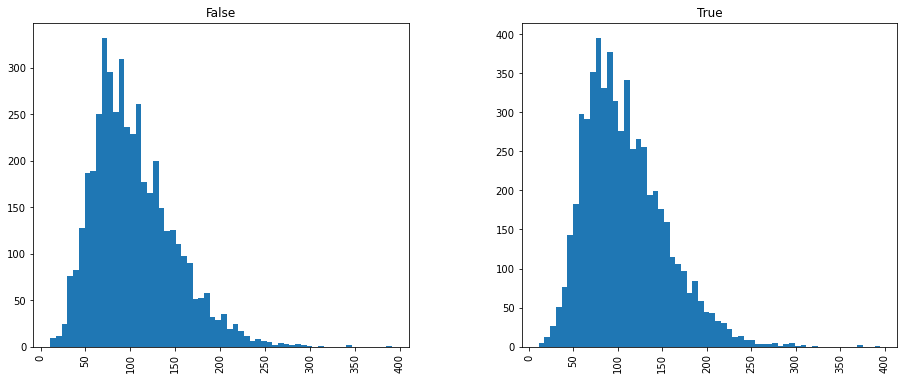

In [7]:
train_news.hist(column='len',by='label',bins=60, figsize=(15,6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x110b77f40>,
      dtype=object)

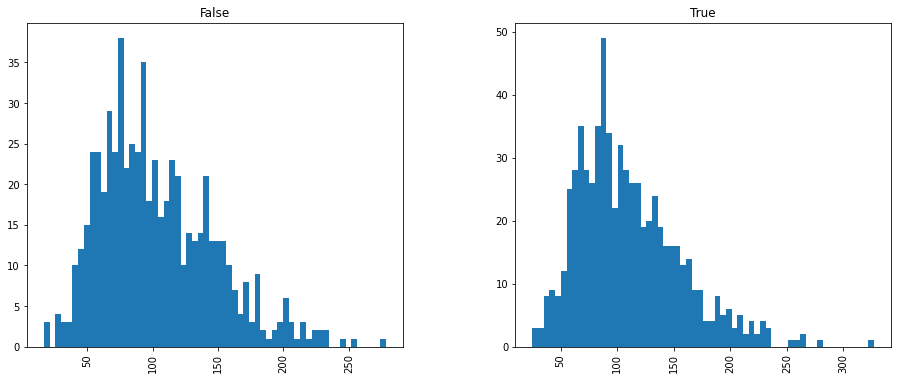

In [9]:
val_news['len'] = val_news['statement'].apply(len)
val_news.hist(column='len',by='label',bins=60, figsize=(15,6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11d047b20>,
      dtype=object)

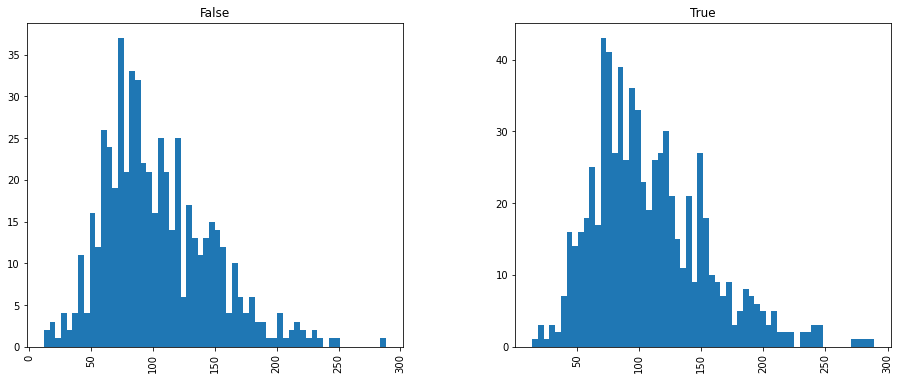

In [13]:
test_news.hist(column='len',by='label',bins=60, figsize=(15,6))

From the above plots, we can see that almost both True and False statements have lengths under 400. Both classes (True & False) are following the same distribution. I don't see a clear pattern between classes.

# Text pre-processing

In [14]:
def process_text(text):
    '''
    What will be covered:
    1. Lower case and remove special characters\whitespaces
    1. Remove punctuation
    2. Remove stopwords
    3. Return list of clean text words
    '''
    #1  
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    
    #2
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    #3
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    #4
    return clean_words

In [15]:
train_news['statement'].apply(process_text).head(10)

0    [Says, Annies, List, political, group, support...
1    [decline, coal, start, started, natural, gas, ...
2    [Hillary, Clinton, agrees, John, McCain, votin...
3    [Health, care, reform, legislation, likely, ma...
4           [economic, turnaround, started, end, term]
5    [Chicago, Bears, starting, quarterbacks, last,...
6    [Jim, Dunnam, lived, district, represents, years]
7    [Im, person, stage, worked, actively, last, ye...
8    [However, took, million, Oregon, Lottery, fund...
9    [Says, GOP, primary, opponents, Glenn, Grothma...
Name: statement, dtype: object

# Feature Weighting

Not all words are equally important to a particular document / category. For example, while words like ‘murder’, ‘knife’ and ‘abduction’ are important to a crime related document, words like ‘news’ and ‘reporter’ may not be quite as important. 

## Binary Weighting
The most basic form of feature weighting, is binary weighting. Where if a word is present in a document, the weight is ‘1’ and if the word is absent the weight is ‘0’. 

## CountVectorizer

It Convert a collection of text documents to a matrix of token counts.

In [16]:
count_vect = CountVectorizer(analyzer=process_text, min_df=0., max_df=1.)
cv_matrix = count_vect.fit_transform(train_news.statement)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [17]:
# get all unique words in the corpus
vocab = count_vect.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,AA,AAA,AARP,ABAs,ABC,ACLU,ACORN,ADVISOR,AFC,AFLCIO,...,youve,yrs,yuppies,zero,zippo,zombies,zone,zones,zoning,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here by doing ‘count_vect.fit_transform(train_news.statement)’, we are learning the vocabulary dictionary and it returns a Document-Term matrix. [n_samples, n_features]

## Tfidf Weighting 

TF-IDF weighting where words that are unique to a particular document would have higher weights compared to words that are used commonly across documents. 

1. TF (Term Frequency): The number of times a word appears in a document divded by the total number of words in the document. Every document has its own term frequency.

2. IDF (Inverse Data Frequency): The log of the number of documents divided by the number of documents that contain the word w. Inverse data frequency determines the weight of rare words across all documents in the corpus.

3. Lastly, the TF-IDF is simply the TF multiplied by IDF.

In [22]:
tfidf_vect = TfidfVectorizer(use_idf=True, max_df=0.95, analyzer=process_text)
tfidf_matrix = tfidf_vect.fit_transform(train_news.statement)
tfidf_matrix = tfidf_matrix.toarray()
tfidf_matrix.shape

(10236, 13617)

In [23]:
print(tfidf_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Visualizing patterns in feature vectors in 2D Space

T-SNE : t-distributed stochastic neighbor embedding [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is a machine learning algorithm for visualization based on Stochastic Neighbor Embedding. It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.

**Training Data**

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


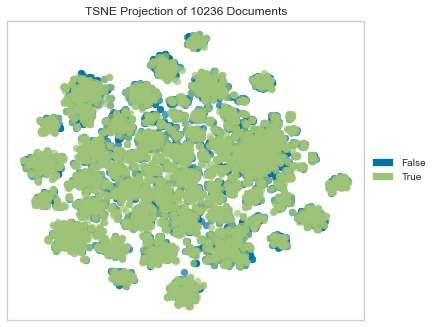

(10236, 13617)


In [24]:
from yellowbrick.text import TSNEVisualizer

tfidf_train_matrix = tfidf_vect.fit_transform(train_news['statement'].values)
# countvect = countv.fit_transform(train_news['statement'].values)

y = train_news.label.values
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(tfidf_train_matrix, y)
tsne.show()

print(tfidfvect.shape)

**Validation Data**

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


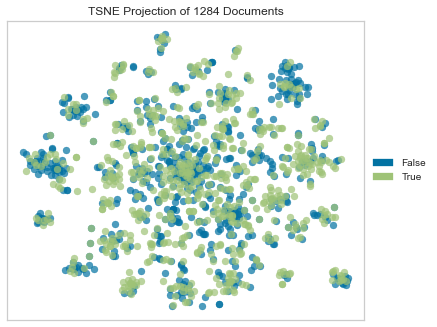

(10236, 13617)


In [25]:
tfidf_val_matrix = tfidf_vect.fit_transform(val_news['statement'].values)
# countvect = countv.fit_transform(val_news['statement'].values)

y = val_news.label.values
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(tfidf_val_matrix, y)
tsne.show()

print(tfidfvect.shape)

**Test Data**

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


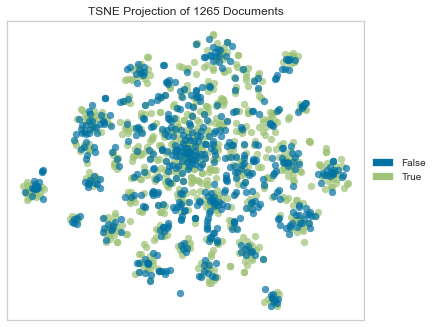

(10236, 13617)


In [26]:
tfidf_test_matrix = tfidf.fit_transform(test_news['statement'].values)
# countvect = countv.fit_transform(test_news['statement'].values)

y = test_news.label.values
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(tfidf_test_matrix, y)
tsne.show()

print(tfidfvect.shape)

T-SNE plots are showing the feature vectors in 2-D space. As you can see, True and False labels are clearly overlapped. No unique pattern is visible and moreover, does not help us to see what is making a news statement to fall into either of the categories. This could be one of the reasons why our models are not doing well with data. We should also try more feature engineering techniques if we want to make sure there is any pattern that exists in the data. 

# Settings up a human benchmark on the data pattern

Let me take 5 True News Statements and 5 false news statements to manually find the pattern.

False News

1. Says the Annies List political group supports third-trimester abortions on demand.
2. Health care reform legislation is likely to mandate free sex change surgeries.
3. Jim Dunnam has not lived in the district he represents for years now.
4. When Mitt Romney was governor of Massachusetts, we didnt just slow the rate of growth of our government, we actually cut it.
5. Most of the (Affordable Care Act) has already in some sense been waived or otherwise suspended.


True News
1. When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
2. Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."
3. The economic turnaround started at the end of my term.
4. The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.
5. I'm the only person on this stage who has worked actively just last year passing, along with Russ Feingold, some of the toughest ethics reform since Watergate.

After manually evaluating the news statements from both classes, I don't see any specific pattern for both. Even if our model performs with 50% accuracy, that will be considered a good model. 